In [4]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
from math import log10
settings.init()

from modules.ClassifierGenerators import (TrainClassifierGenerator,  # noqa
                                          ValidationClassifierGenerator)  # noqa

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# assumes that array is not zero
def scaled(tensor):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
                                                math.reduce_min(tensor))
def scaled_array(array):
    return (array - np.min(array))/(np.max(array) - np.min(array))

TRAIN_DATA_LEN: 3720334
VAL_DATA_LEN: 1593071


In [5]:
train = pd.read_csv('data_info.csv')

In [2]:
from modules.DataPreprocessor import DataLoader
dl = DataLoader()
audio = dl.load_audio_binary(505)[:,0]
complex_image = dl.make_spectrogram(505)
recovered_Zxx = complex_image[:,:,0] + 1j*complex_image[:,:,1]
t, x = scipy.signal.istft(recovered_Zxx, fs=48000, window='hann',                                      nperseg=48000/16, noverlap=16)

In [3]:
complex_image.shape

(1501, 59, 3)

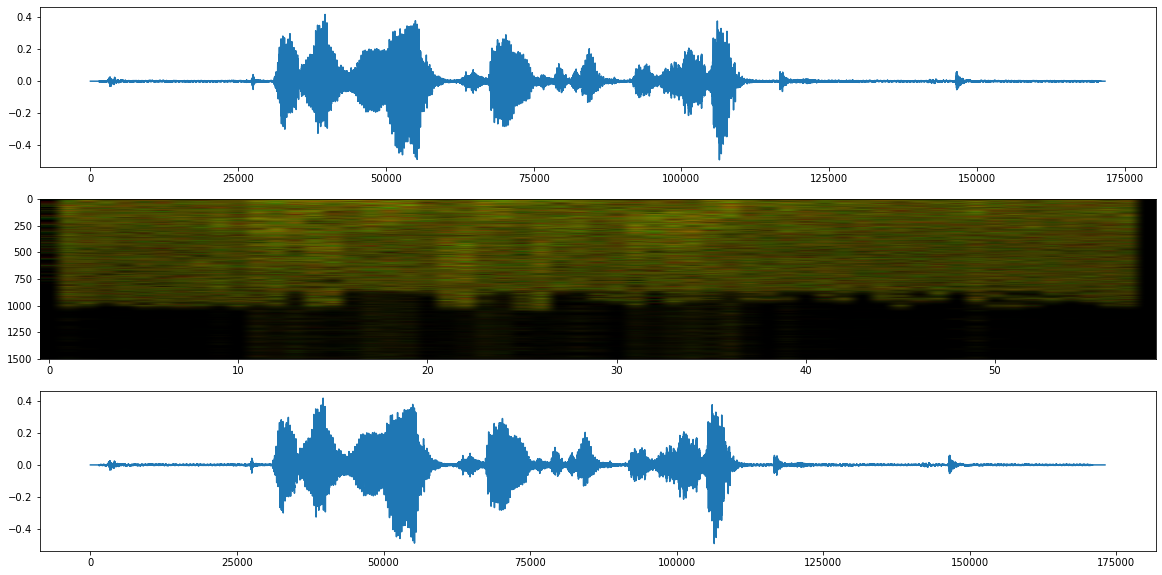

In [4]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=3)
ax[0].plot(audio)
ax[1].imshow(scaled_array(dl.power_to_db(complex_image)), cmap='plasma', aspect='auto')
ax[2].plot(x)

In [5]:
recovered_Zxx.shape

(1501, 59)

In [6]:
from scipy.io.wavfile import write

scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
write('testOG.wav', 48000, scaled)

scaled2 = np.int16(x/np.max(np.abs(x)) * 32767)
write('test_recovered.wav', 48000, scaled2)

In [7]:
import scipy.spatial.distance as dist
def similarity(x1, x2):
    distance = dist.euclidean(x1, x2)
    return 1/(1+distance)
similarity(audio, x[:len(audio)])

0.9988579996278117

In [8]:
 def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

def power_to_db(S, amin=1e-16, top_db=80.0):
    ref = tf.reduce_max(S)
    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))
    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)
    return log_spec

In [9]:
zxc = np.array([5.0, 2.0, 4.0, 100, -100])+100
power_to_db(tf.convert_to_tensor(zxc))

<tf.Tensor: shape=(5,), dtype=float64, numpy=
array([ -2.79840697,  -2.92429824,  -2.83996656,   0.        ,
       -80.        ])>

In [10]:
db_to_power(
    power_to_db(tf.convert_to_tensor(zxc))
)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([5.25e-01, 5.10e-01, 5.20e-01, 1.00e+00, 1.00e-08])>